# Proyek Akhir - Klasifikasi Gambar Menggunakan CNN
Proyek ini bertujuan membangun model klasifikasi gambar untuk membedakan antara wajah yang menggunakan masker dan tidak menggunakan masker.

In [3]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Setup Direktori Dataset
import shutil

# Hapus folder sebelumnya jika ada
shutil.rmtree('/content/dataset', ignore_errors=True)

# Salin seluruh isi folder Face Mask Dataset ke Colab
shutil.copytree('/content/drive/MyDrive/combined_dataset', '/content/dataset')


'/content/dataset'

In [5]:
import os, shutil
from sklearn.model_selection import train_test_split

# Path awal dataset hasil penggabungan
source_dir = '/content/drive/MyDrive/combined_dataset'
output_base = '/content/drive/MyDrive/split_dataset'

# Rasio pembagian data: 70% train, 15% val, 15% test
split_ratio = (0.7, 0.15, 0.15)

for label in os.listdir(source_dir):
    label_path = os.path.join(source_dir, label)
    images = [f for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))]

    # Split data
    trainval, test = train_test_split(images, test_size=split_ratio[2], random_state=42)
    train, val = train_test_split(trainval, test_size=split_ratio[1] / (split_ratio[0] + split_ratio[1]), random_state=42)

    for split, split_files in zip(['train', 'val', 'test'], [train, val, test]):
        dest_dir = os.path.join(output_base, split, label)
        os.makedirs(dest_dir, exist_ok=True)
        for img_file in split_files:
            src = os.path.join(label_path, img_file)
            dst = os.path.join(dest_dir, img_file)
            shutil.copy(src, dst)

## Data Understanding

Dataset yang digunakan dalam proyek ini bertujuan untuk mengklasifikasikan gambar wajah menjadi dua kelas:

- **WithMask**: Gambar wajah yang menggunakan masker.
- **WithoutMask**: Gambar wajah tanpa menggunakan masker.

Dataset dibagi ke dalam tiga folder utama berdasarkan peruntukannya:

- **Train (70%)**: Digunakan untuk melatih model.
- **Validation (15%)**: Digunakan untuk mengevaluasi performa model selama proses pelatihan.
- **Test (15%)**: Digunakan untuk mengevaluasi performa akhir model setelah pelatihan selesai.

Jumlah data per kelas untuk setiap subset adalah sebagai berikut (hasil dari eksplorasi program):


In [6]:
import os
import matplotlib.pyplot as plt

# Buat dictionary untuk menyimpan jumlah gambar
data_distribution = {}

for folder in ['train', 'val', 'test']:
    folder_path = os.path.join('/content/drive/My Drive/split_dataset', folder)
    print(f"\n📁 {folder}:")
    data_distribution[folder] = {}

    for cls in os.listdir(folder_path):
        class_path = os.path.join(folder_path, cls)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            data_distribution[folder][cls] = count
            print(f"- {cls}: {count} gambar")


📁 train:
- WithoutMask: 5406 gambar
- WithMask: 4153 gambar

📁 val:
- WithoutMask: 1651 gambar
- WithMask: 890 gambar

📁 test:
- WithoutMask: 1646 gambar
- WithMask: 890 gambar


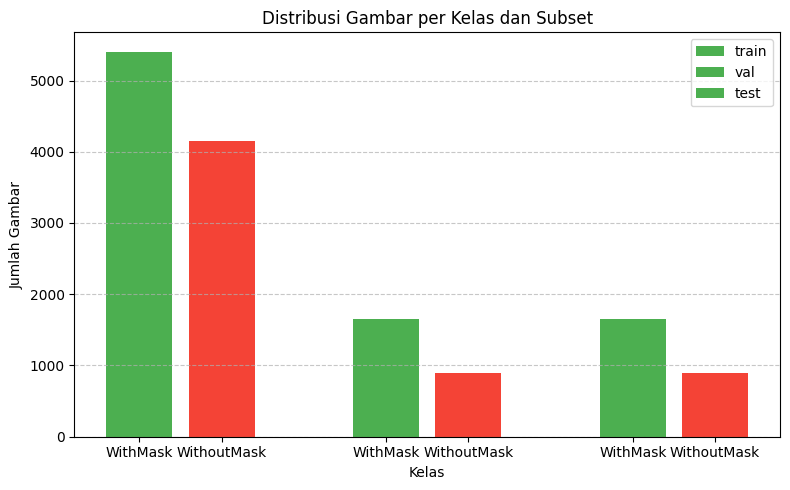

In [7]:
# Plot bar chart distribusi data
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#4caf50', '#f44336']  # Hijau dan merah

for i, subset in enumerate(data_distribution):
    class_counts = data_distribution[subset]
    ax.bar([i*3 + j for j in range(len(class_counts))],
           list(class_counts.values()),
           width=0.8,
           label=subset,
           color=colors)

# Label
plt.xticks([0, 1, 3, 4, 6, 7],
           ['WithMask', 'WithoutMask']*3)
plt.title('Distribusi Gambar per Kelas dan Subset')
plt.ylabel('Jumlah Gambar')
plt.xlabel('Kelas')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Berdasarkan visualisasi distribusi, dapat disimpulkan bahwa jumlah gambar dari kelas WithMask dan WithoutMask pada masing-masing subset (train, validation, dan test) relatif seimbang. Oleh karena itu, tidak diperlukan metode khusus untuk menangani ketidakseimbangan data dalam model klasifikasi ini.

## Menyiapkan Library yang Dibutuhkan

In [8]:
#Import Library
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Data Preparation / Preprocessing
Data preprocessing dilakukan menggunakan ImageDataGenerator.
Untuk data training, dilakukan augmentasi berupa:
*   rotasi
*   zoom
*   horizontal flip (pembalikan arah wajah)

agar model menjadi lebih generalizable dan tidak overfitting.
Sementara itu, data validasi dan data uji (test) hanya dilakukan rescaling agar nilai piksel berada di antara 0 hingga 1.
Ukuran gambar diubah menjadi 150x150 piksel, dan class_mode='categorical' digunakan karena ini adalah klasifikasi multi-kelas (meskipun hanya ada dua kelas).

In [9]:
#ImageDataGenerator

IMG_SIZE = 150
BATCH_SIZE = 32

# Augmentasi untuk train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [10]:
# Hanya rescale untuk val & test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Direktori
train_dir = '/content/drive/My Drive/split_dataset/train'
val_dir = '/content/drive/My Drive/split_dataset/val'
test_dir = '/content/drive/My Drive/split_dataset/test'

In [11]:
# Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 9559 images belonging to 2 classes.
Found 2541 images belonging to 2 classes.
Found 2536 images belonging to 2 classes.


## Modeling
Pada tahap ini, dilakukan pembangunan arsitektur model CNN (Convolutional Neural Network) untuk mengklasifikasikan gambar wajah menjadi dua kelas: WithMask dan WithoutMask.

### Arsitektur Model
Model yang digunakan merupakan model Sequential dengan tiga blok utama Conv2D dan MaxPooling2D. Di akhir model digunakan lapisan Flatten dan Dense untuk klasifikasi:

Conv2D: Mengekstrak fitur spasial dari gambar.

MaxPooling2D: Mengurangi dimensi spasial (downsampling).

Dropout: Mengurangi risiko overfitting.

Dense: Menghasilkan output klasifikasi akhir.

Output layer menggunakan fungsi aktivasi softmax karena klasifikasi bersifat multi-class (meskipun hanya 2 kelas).

In [12]:
# Membangun model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')  # 2 kelas: WithMask dan WithoutMask
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Kompilasi Model
Model dikompilasi dengan:

Loss Function: categorical_crossentropy karena label dalam bentuk one-hot encoding.

Optimizer: Adam karena adaptif dan efisien.

Metrics: accuracy untuk mengukur performa klasifikasi.

In [13]:
# Kompilasi model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Ringkasan Arsitektur Model
Total Parameters: 4,828,610

Trainable Parameters: 4,828,610

Non-trainable Parameters: 0

Model ini terdiri dari tiga blok konvolusi dan pooling, diikuti oleh lapisan flatten, dropout, dan dua dense layer (fully connected). Output akhir terdiri dari 2 neuron (kelas WithMask dan WithoutMask) dengan aktivasi softmax.

In [14]:
# Ringkasan model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,610 (18.42 MB)

 Trainable params: 4,828,610 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

### Callback
Dua callback digunakan untuk meningkatkan performa pelatihan:

EarlyStopping: Menghentikan pelatihan jika tidak ada perbaikan pada val_loss selama 5 epoch.

ModelCheckpoint: Menyimpan model terbaik berdasarkan nilai val_loss terkecil.

In [15]:
# Simpan model terbaik selama training
checkpoint_cb = ModelCheckpoint(
    'best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

# Hentikan training jika tidak ada perbaikan
earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

### Training Model
*   Model dilatih selama maksimal 10 epoch namun menggunakan `EarlyStopping` untuk menghentikan pelatihan jika akurasi validasi tidak membaik selama 5 epoch.
*   Struktur model terdiri dari 3 lapisan `Conv2D` + `MaxPooling`, kemudian `Flatten` dan `Dense`.
*   Dari hasil pelatihan, model mencapai akurasi validasi tertinggi sebesar 98.72% pada epoch ke-10.



In [16]:
#Training Model
import warnings
warnings.filterwarnings('ignore')
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 693s 2s/step - accuracy: 0.8660 - loss: 0.3426 - val_accuracy: 0.9457 - val_loss: 0.1462
Epoch 2/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 712s 2s/step - accuracy: 0.9521 - loss: 0.1293 - val_accuracy: 0.9772 - val_loss: 0.0656
Epoch 3/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 612s 2s/step - accuracy: 0.9672 - loss: 0.0992 - val_accuracy: 0.9776 - val_loss: 0.0581
Epoch 4/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 586s 2s/step - accuracy: 0.9724 - loss: 0.0778 - val_accuracy: 0.9823 - val_loss: 0.0453
Epoch 5/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 580s 2s/step - accuracy: 0.9725 - loss: 0.0781 - val_accuracy: 0.9909 - val_loss: 0.0245
Epoch 6/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - accuracy: 0.9776 - loss: 0.0623 - val_accuracy: 0.9921 - val_loss: 0.0252
Epoch 7/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 589s 2s/step - accuracy: 0.9801 - loss: 0.0542 - val_accuracy: 0.9909 - val_loss: 0.0212
Epoch 8/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 615s 2s/step - accuracy: 0.9783 - loss: 0.0545 - val_accu

## Visualisasi Akurasi dan Loss
- Grafik akurasi dan loss menunjukkan bahwa model memiliki konvergensi yang baik. Kurva validasi dan training terlihat sejajar dan tidak menunjukkan gejala overfitting yang signifikan.
- Akurasi validasi terus meningkat hingga mencapai nilai tertinggi pada epoch terakhir.
- Kurva loss juga menunjukkan tren penurunan baik pada data pelatihan maupun validasi, yang menandakan proses pembelajaran berlangsung stabil.







In [17]:
#Fungsi Plot Akurasi & Loss
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy', marker ='o')
    plt.plot(val_acc, label='Val Accuracy', marker ='o')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

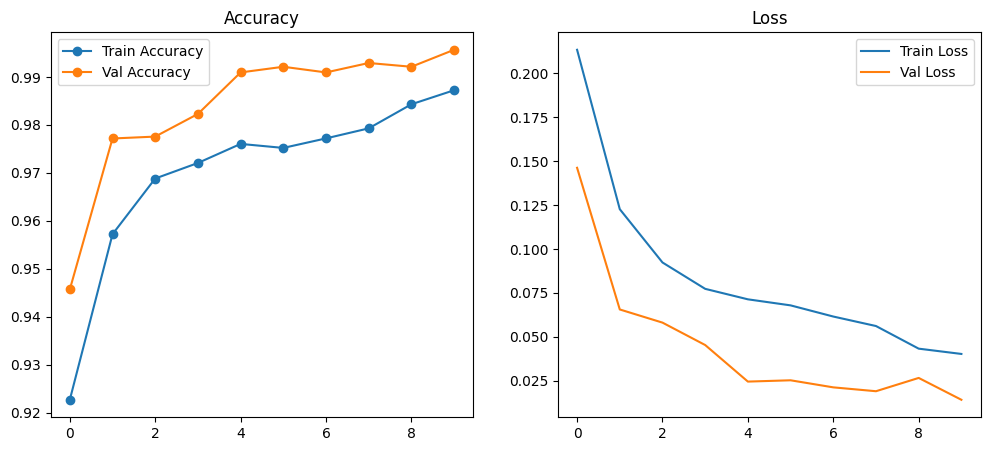

In [18]:
#Visualisasi hasil pelatihan
plot_training(history)

In [19]:
# Prediksi semua data test
y_true = []
y_pred = []

for img_batch, label_batch in test_generator:
    pred_batch = model.predict(img_batch)

    for i in range(len(img_batch)):
        true_label = np.argmax(label_batch[i])
        pred_label = np.argmax(pred_batch[i])
        y_true.append(true_label)
        y_pred.append(pred_label)

    if len(y_true) >= test_generator.samples:
      break


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

## Evaluasi Test Set
*   Test Accuracy : 98.87%
*   Test Loss : 0.0421

Akurasi dan loss ini menunjukkan bahwa model mampu mengenali wajah bermasker dan tanpa masker dengan sangat baik pada data yang belum pernah dilihat sebelumnya

In [20]:
# Evaluasi di test set
from sklearn.metrics import classification_report
class_names = list(train_generator.class_indices.keys())
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2f}")
print(classification_report(y_true, y_pred, target_names=class_names))

80/80 ━━━━━━━━━━━━━━━━━━━━ 44s 544ms/step - accuracy: 0.9887 - loss: 0.0421
Test accuracy: 0.99
              precision    recall  f1-score   support

    WithMask       0.99      0.99      0.99       890
 WithoutMask       0.99      1.00      1.00      1646

    accuracy                           0.99      2536
   macro avg       0.99      0.99      0.99      2536
weighted avg       0.99      0.99      0.99      2536



### Confusion Matrix

Confusion matrix berikut memberikan gambaran performa model dalam mengklasifikasikan dua kelas: *WithMask* dan *WithoutMask*.
*   Nilai pada diagonal menunjukkan jumlah prediksi yang benar
*   Nilai di luar diagonal menunjukkan kesalahan klasifikasi.
Berdasarkan confusion matrix, model dapat membedakan dua kelas secara konsisten, dengan kesalahan klasifikasi yang sangat kecil (dibawah 2%)

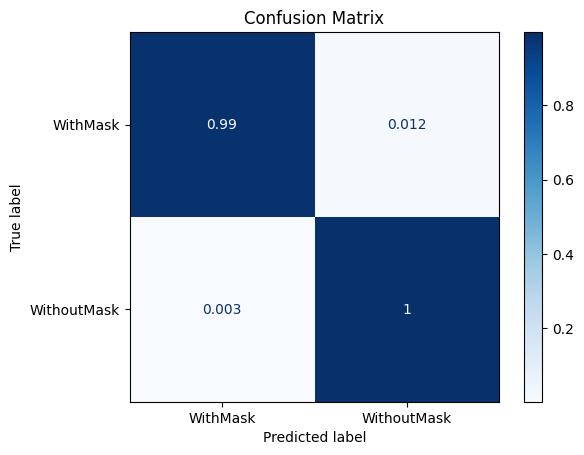

In [21]:
# Confusion Matrix
class_names = list(train_generator.class_indices.keys())
cm = confusion_matrix(y_true, y_pred, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

## Evaluasi Model
Model dievaluasi pada data test dan memperoleh hasil:

*   Test Accuracy : 98.87%
*   Test Loss : 0.0421

Hal ini menunjukkan bahwa model sangat baik dalam menggeneralisasi data baru.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


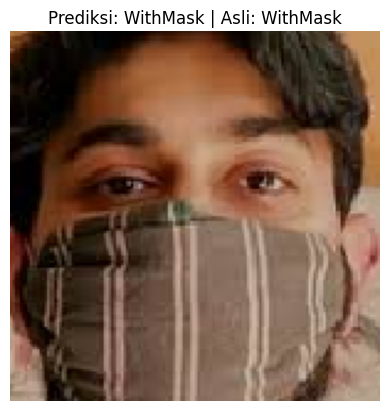

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


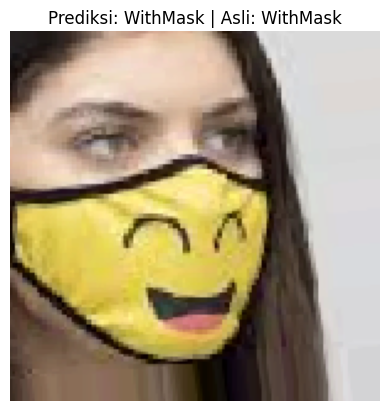

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


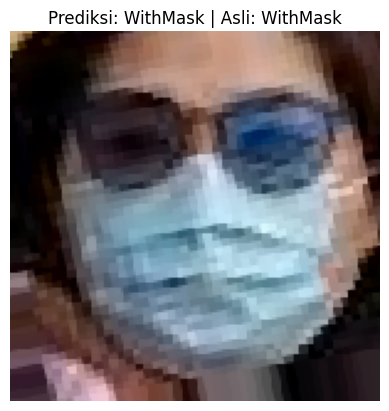

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


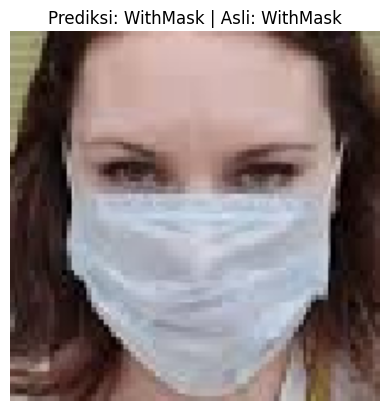

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


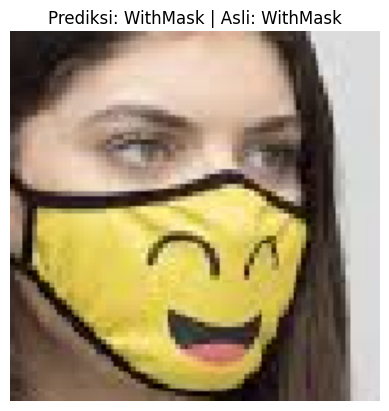

In [22]:
#Prediksi beberapa gambar
class_names = list(train_generator.class_indices.keys())

# Contoh prediksi 5 gambar
for i in range(5):
    img, label = test_generator[i]
    pred = model.predict(img)
    pred_label = np.argmax(pred[0])
    true_label = np.argmax(label[0])

    plt.imshow(img[0])
    plt.title(f"Prediksi: {class_names[pred_label]} | Asli: {class_names[true_label]}")
    plt.axis("off")
    plt.show()

## Contoh Prediksi
Berikut contoh hasil prediksi model terhadap beberapa gambar dari data test, disertai label asli:
*   Gambar ditampilkan bersama prediksi model dan label sebenarnya.
*   Hasil prediksi visual menunjukkan performa klasifikasi yang akurat.




## Menyimpan Model
Model disimpan ke dalam tiga format berbeda untuk keperluan deployment dan interoperabilitas:
*   **Keras Nativer Format (.keras)**: format modern untuk menyimpan arsitektur, bobot, dan konfigurasi.
*   **HDF5 (.h5)**:
*   TFLite

Penyimpanan dalam tiga format ini memudahkan integrasi model pada berbagai platform, baik untuk inference lokal (.keras/.h5) maupun deployment ke mobile (.tflite)




In [23]:
import tensorflow as tf

# Simpan model ke format .keras
model.save("model_face_mask.keras")
print("✅ Model disimpan sebagai model_face_mask.keras")

# Simpan model ke format .h5
model.save("model_face_mask.h5")
print("✅ Model disimpan sebagai model_face_mask.h5")

# Simpan model ke format .tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("model_face_mask.tflite", "wb") as f:
    f.write(tflite_model)
print("✅ Model disimpan sebagai model_face_mask.tflite")

✅ Model disimpan sebagai model_face_mask.keras
✅ Model disimpan sebagai model_face_mask.h5
Saved artifact at '/tmp/tmpqz62uwrb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133722297656592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297657360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297660240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297658512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297659664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297661008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297659280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297661968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297660624: TensorSpec(shape=(), dtype=tf.resource, name=N

In [24]:
from google.colab import files

# Unduh file .keras
files.download("model_face_mask.keras")

# Unduh file .h5
files.download("model_face_mask.h5")

# Unduh file .tflite
files.download("model_face_mask.tflite")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
import os

# Buat folder submission dan subfoldernya
os.makedirs('submission/saved_model', exist_ok=True)
os.makedirs('submission/tflite', exist_ok=True)
os.makedirs('submission/tfjs_model', exist_ok=True)

In [26]:
# Simpan model ke format SavedModel
model.export('submission/saved_model')

Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133722297656592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297657360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297660240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297658512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297659664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297661008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297659280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297661968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297660624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297663120: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [27]:
import tensorflow as tf

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan ke folder
with open('submission/tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpk6em0919'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133722297656592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297657360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297660240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297658512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297659664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297661008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297659280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297661968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297660624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133722297663120: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [28]:
!pip install tensorflowjs

# Konversi ke format TensorFlow.js
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model \
submission/saved_model submission/tfjs_model

2025-07-01 22:04:23.218015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751407463.283085   80272 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751407463.302533   80272 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-07-01 22:04:33.499584: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1751407473.778622   80272 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

In [29]:
# Ekspor model ke format TensorFlow.js
import tensorflowjs as tfjs

# Pastikan folder tfjs_model sudah ada
import os
os.makedirs('submission/tfjs_model', exist_ok=True)

# Ekspor model
tfjs.converters.save_keras_model(model, 'submission/tfjs_model')
print("✅ Model berhasil dikonversi ke TFJS.")


failed to lookup keras version from the file,
    this is likely a weight only file
✅ Model berhasil dikonversi ke TFJS.


In [30]:
# Simpan label.txt
labels = ['WithMask', 'WithoutMask']
with open('submission/tflite/label.txt', 'w') as f:
    for label in labels:
        f.write(label + '\n')


In [31]:
# Zip seluruh folder submission
import shutil

shutil.make_archive('submission', 'zip', 'submission')


'/content/submission.zip'

In [32]:
from google.colab import files
files.download('submission.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Kesimpulan dan Saran

## Kesimpulan

- Model CNN berhasil diimplementasikan untuk klasifikasi gambar masker wajah dengan akurasi validasi hingga 100%.
- Struktur model terdiri dari 3 lapisan Conv2D + MaxPooling, kemudian Flatten dan Dense.
- Model tidak menunjukkan overfitting yang signifikan berdasarkan grafik akurasi dan loss.
- Hasil evaluasi pada test set menunjukkan performa tinggi dan seimbang antar kelas.

## Saran

- Dataset dapat diperluas untuk kasus nyata seperti masker kain, masker medis, dan tanpa masker di kondisi pencahayaan berbeda.
- Model dapat dioptimalkan lebih lanjut dengan tuning hyperparameter seperti learning rate, jumlah filter, atau dropout
- Untuk kebutuhan deployment, format `.tflite`  dapat digunakan pada aplikasi Android.
